## A python interactive code for an RL circuit.
- **Author**: Mohamed Saeed.
- **Date of completion**: 2/3/2025
- **Tools used for assistance**: Claude AI

Run the cells in order. You'll find the interactive code in cell 6.

**Imports** all necessary Python libraries for numerical computations, plotting, differential equation solving, symbolic mathematics, and interactive widgets.

In [1]:
# Cell 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
from ipywidgets import interact #interactive, #fixed, #interact_manual
import ipywidgets as widgets
#import matplotlib.animation as animation
#from IPython.display import display, HTML

**Defines** the main class for RL circuit simulation. Contains methods for:

- Circuit initialization
- Differential equation definition
- Circuit simulation
- Results calculation

In [2]:
# Cell 2: Define the SeriesRLCircuit Class
class SeriesRLCircuit:
    def __init__(self, resistance, inductance):
        """Initialize the series RL circuit with resistance and inductance values."""
        self.R = resistance
        self.L = inductance
        
    def differential_equation(self, t, y, voltage_func):
        """Define the differential equation for the RL circuit."""
        i = y[0]
        v = voltage_func(t)
        di_dt = (v - self.R * i) / self.L
        return [di_dt]
    
    def simulate(self, voltage_func, t_span, num_points=1000):
        """Simulate the circuit response over time."""
        y0 = [0]
        t_eval = np.linspace(t_span[0], t_span[1], num_points)
        solution = solve_ivp(
            fun=lambda t, y: self.differential_equation(t, y, voltage_func),
            t_span=t_span,
            y0=y0,
            t_eval=t_eval,
            method='RK45'
        )
        
        currents = solution.y[0]
        resistor_voltages = currents * self.R
        source_voltages = np.array([voltage_func(t) for t in solution.t])
        inductor_voltages = self.L * np.gradient(currents, solution.t)
        
        return solution.t, currents, resistor_voltages, source_voltages, inductor_voltages

**Defines** various input voltage waveform generators:

- Sine wave
- Square wave
- Sawtooth wave
- Triangle wave
- DC voltage
- Custom waveform

In [3]:
# Cell 3: Define Waveform Functions
def sine_wave(amplitude, frequency, phase=0):
    return lambda t: amplitude * np.sin(2 * np.pi * frequency * t + phase)

def square_wave(amplitude, frequency, duty_cycle=0.5):
    return lambda t: amplitude if (t * frequency) % 1 < duty_cycle else 0

def sawtooth_wave(amplitude, frequency):
    return lambda t: amplitude * ((t * frequency) % 1)

def triangle_wave(amplitude, frequency):
    return lambda t: amplitude * (2 * abs(2 * ((t * frequency) % 1) - 1) - 1)

def dc_voltage(amplitude):
    return lambda t: amplitude

def custom_waveform(expression_str, t_symbol='t'):
    t = sp.Symbol(t_symbol)
    expr = sp.sympify(expression_str)
    func = sp.lambdify(t, expr, modules=["numpy"])
    return func

**Creates** a plot showing how voltage distributes between the resistor and inductor over time

In [4]:
# Cell 4: Define Visualization Functions
def plot_voltage_division(times, source_voltage, resistor_voltage, inductor_voltage):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(times, source_voltage, 'k-', label='Source Voltage')
    plt.plot(times, resistor_voltage, 'r-', label='Resistor Voltage')
    plt.plot(times, inductor_voltage, 'b-', label='Inductor Voltage')
    plt.title('Voltage Distribution in RL Circuit')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


**run_simulation:** Coordinates the entire simulation process
- Creates the circuit with specified parameters
- Selects and configures the input voltage waveform
- Runs the simulation and calculates results
- Displays key statistics (time constant, max/min/RMS voltages)
- Generates visualizations of the circuit behavior

In [5]:
# Cell 5: Define Main Simulation Function
def run_simulation(R, L, waveform_type, amplitude, frequency=1, duty_cycle=0.5, custom_expr=''):
    # Create circuit
    circuit = SeriesRLCircuit(R, L)
    
    # Select waveform
    if waveform_type == 'Sine':
        voltage_func = sine_wave(amplitude, frequency)
        waveform_name = f"Sine wave ({amplitude}V, {frequency}Hz)"
    elif waveform_type == 'Square':
        voltage_func = square_wave(amplitude, frequency, duty_cycle)
        waveform_name = f"Square wave ({amplitude}V, {frequency}Hz)"
    elif waveform_type == 'Sawtooth':
        voltage_func = sawtooth_wave(amplitude, frequency)
        waveform_name = f"Sawtooth wave ({amplitude}V, {frequency}Hz)"
    elif waveform_type == 'Triangle':
        voltage_func = triangle_wave(amplitude, frequency)
        waveform_name = f"Triangle wave ({amplitude}V, {frequency}Hz)"
    elif waveform_type == 'DC':
        voltage_func = dc_voltage(amplitude)
        waveform_name = f"DC voltage ({amplitude}V)"
        frequency = 0
    else:  # Custom
        try:
            voltage_func = custom_waveform(custom_expr)
            waveform_name = f"Custom waveform: {custom_expr}"
        except:
            print("Error in custom expression. Using sine wave instead.")
            voltage_func = sine_wave(amplitude, frequency)
            waveform_name = f"Sine wave ({amplitude}V, {frequency}Hz)"
    
    # Set simulation parameters
    if frequency > 0:
        t_end = 5 / frequency
    else:
        time_constant = circuit.L / circuit.R
        t_end = 5 * time_constant
    
    t_span = (0, t_end)
    
    # Run simulation
    times, currents, resistor_voltages, source_voltages, inductor_voltages = circuit.simulate(voltage_func, t_span)
    
    # Display results
    print(f"\nTime constant (L/R): {circuit.L/circuit.R:.6f} seconds")
    print(f"Maximum voltage across resistor: {np.max(resistor_voltages):.4f} V")
    print(f"Minimum voltage across resistor: {np.min(resistor_voltages):.4f} V")
    print(f"RMS voltage across resistor: {np.sqrt(np.mean(resistor_voltages**2)):.4f} V")
    
    # Plot results
    plot_voltage_division(times, source_voltages, resistor_voltages, inductor_voltages)
    

- **Creates** an interactive widget-based UI
- Provides input fields for all circuit parameters:

    - Resistance and inductance values
    - Waveform type selection
    - Amplitude and frequency controls
    - Duty cycle slider for square waves
     -Custom expression input

- Updates simulation results in real-time as parameters change

In [ ]:
# Cell 6: Create Interactive Interface
interact(run_simulation,
        R=widgets.FloatText(value=100.0, description='Resistance (Ω):'),
        L=widgets.FloatText(value=0.1, description='Inductance (H):'),
        waveform_type=widgets.Dropdown(
            options=['Sine', 'Square', 'Sawtooth', 'Triangle', 'DC', 'Custom'],
            value='Sine',
            description='Waveform:'
        ),
        amplitude=widgets.FloatText(value=5.0, description='Amplitude (V):'),
        frequency=widgets.FloatText(value=1.0, description='Frequency (Hz):'),
        duty_cycle=widgets.FloatSlider(
            value=0.5,
            min=0,
            max=1.0,
            step=0.1,
            description='Duty Cycle:'
        ),
        custom_expr=widgets.Text(
            value='sin(2*pi*t)',
            description='Custom Expression:'
        )
)

interactive(children=(FloatText(value=100.0, description='Resistance (Ω):'), FloatText(value=0.1, description=…

<function __main__.run_simulation(R, L, waveform_type, amplitude, frequency=1, duty_cycle=0.5, custom_expr='')>

**Below is an example of a scenario for a power line filter:**

- Resistance: 50 Ω (filter resistance)
- Inductance: 10 mH (filter inductance)
- Waveform: Square
- Amplitude: 5 V (digital signal)
- Frequency: 100 kHz (100000 Hz)
- Duty Cycle: 0.5

we can see that This circuit is effectively acting as a low-pass filter,
The high-frequency components of the square wave are being attenuated
The resistor voltage (which is proportional to current) will be much smoother than the input square wave

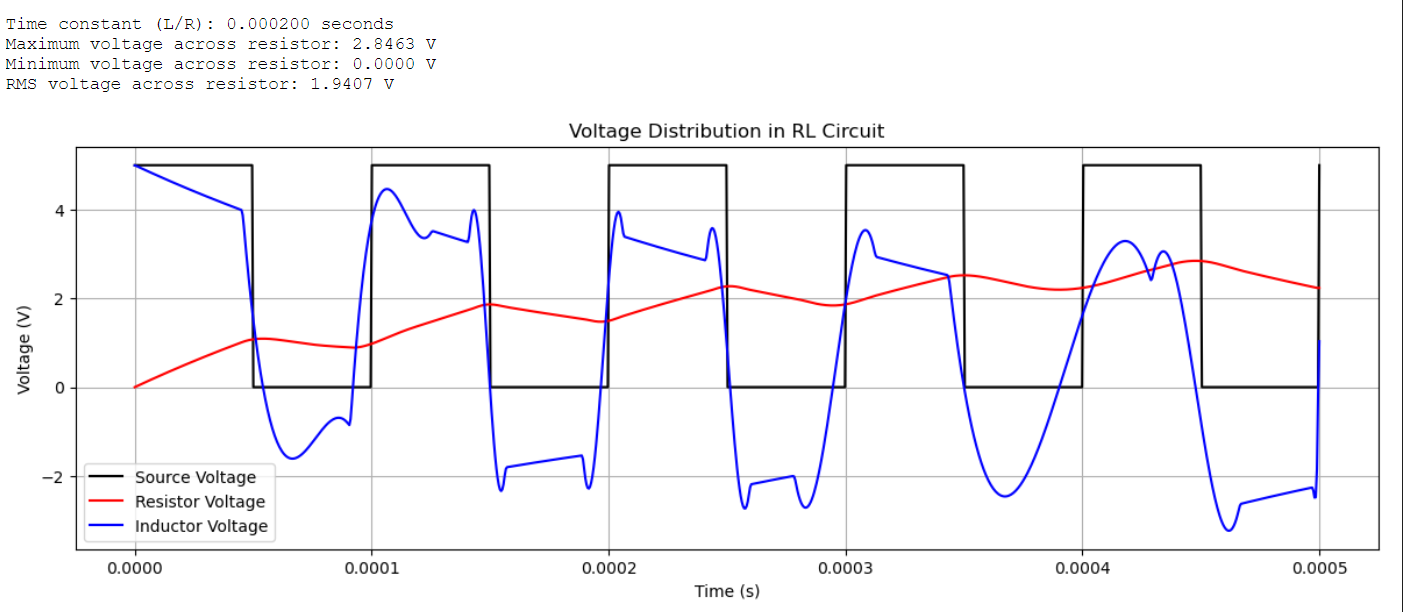

You can now use the interactive panel to test many real wold scenarios like:

- Motor Starting Circuit
- Solenoid Actuator
- Pulse Width Modulation (PWM) Control.
  
and much more!
The code can be improved further, like for example making a calculation and visualization for currents in the circuit.